In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [14]:
# All the imports
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from torch import nn, optim
import torch.nn.functional as F
from sklearn.metrics import classification_report, confusion_matrix
from joblib import dump, load
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
import imblearn.over_sampling 
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from nltk.corpus import wordnet
import random
from sklearn.base import BaseEstimator, TransformerMixin


In [15]:
# load data
path_detail_df = pd.read_csv("path_detail.csv")
player_metrics_df = pd.read_csv("player_metrics.csv")
print(player_metrics_df.columns)
print(path_detail_df.columns)

Index(['pid', 'fnm', 'lnm', 'hght', 'n', 'bx', 'by', 'bz', 'rt', 'rx', 'ry',
       'rz', 'rv', 'rvx', 'rvy', 'rvz', 'mnv', 'mnvt', 'mnvx', 'mnvy', 'mnvz',
       'mxv', 'mxvt', 'mxvx', 'mxvy', 'mxvz', 'ta1t', 'ta1x', 'ta1y', 'ta1z',
       'ta2t', 'ta2x', 'ta2y', 'ta2z', 'at1t', 'at1x', 'at1y', 'at1z', 'at2t',
       'at2x', 'at2y', 'at2z', 'lr1t', 'lr1x', 'lr1y', 'lr1z', 'lr2t', 'lr2x',
       'lr2y', 'lr2z', 'rl1t', 'rl1x', 'rl1y', 'rl1z', 'rl2t', 'rl2x', 'rl2y',
       'rl2z', 'pl', 'spl', 'plr'],
      dtype='object')
Index(['pid', 'fnm', 'lnm', 'hght', 't', 'ddst', 'cx', 'cy', 'cz', 'cvx',
       'cvy', 'cvz', 'cv', 'cax', 'cay', 'caz', 'ca', 'rt', 'dx', 'dy', 'dz',
       'd'],
      dtype='object')


In [16]:
import pandas as pd

# Define custom aggregation function to take every third element and limit to 100 points
def take_every_third_and_limit(x):
    return x[::15][:20]  # Takes every third element and limits to the first 100 points

agg_path_detail_df = path_detail_df.groupby('pid').agg({
    'cy': lambda x: take_every_third_and_limit(list(x)),
    'cz': lambda x: take_every_third_and_limit(list(x)),
    'fnm': 'first',  # or 'last' or another appropriate aggregation function
    'lnm': 'first'   # or 'last' or another appropriate aggregation function
}).reset_index()

# Filter for specific 'pid' values
condition = agg_path_detail_df['pid'].isin([201935, 203081, 201142, 201939, 202691, 202681])
agg_path_detail_df = agg_path_detail_df.loc[condition]

# Display the first few rows
agg_path_detail_df.head()
# print(len(agg_path_detail_df.head()))
agg_path_detail_df.head(6)


,pid,cy,cz,fnm,lnm
57,201142,"[0.1680160363903216, 0.2356226793842775, 0.301...","[3.4031525766674697, 3.536222492003237, 3.7007...",Kevin,Durant
88,201935,"[0.1680846790289842, 0.119290607812078, 0.0731...","[3.3473054010159005, 3.444111705324316, 3.5663...",James,Harden
91,201939,"[0.1336904216733061, 0.1635036134360679, 0.191...","[3.262894407651078, 3.4188976431704203, 3.5943...",Stephen,Curry
125,202681,"[-0.0448569109508567, 0.026035270981794, 0.092...","[2.854115540659227, 2.8640449035781943, 2.8952...",Kyrie,Irving
129,202691,"[0.0770202130607479, 0.0983300565439261, 0.118...","[3.593299792613544, 3.660719236941019, 3.75459...",Klay,Thompson
146,203081,"[-0.1810506627386712, -0.1170564467226992, -0....","[2.9692300460026178, 3.077672250501492, 3.2074...",Damian,Lillard


In [17]:
# Create a list to store scaled rows
scaled_rows = []

# Initialize MinMaxScaler
scaler = MinMaxScaler()

for i in range(len(agg_path_detail_df)):
    row = agg_path_detail_df.iloc[i]
    scaled_row = row.copy()
    
    for col in ['cy', 'cz']:
        try:
            # Debug print to inspect the data type and content
#             print(f"\nRow {i} - Column {col} - Data type: {type(row[col])}")
#             print(f"Data before scaling: {row[col]}")

            # Ensure the data is a list before processing
            if isinstance(row[col], list):
                # Convert the column data to numpy array for scaling
                data_array = np.array(row[col]).reshape(-1, 1)
                
                # Debug print to inspect data before scaling
#                 print(f"Before scaling - Row: {i}, Column: {col}, Data: {data_array}")
                
                # Fit the scaler to your data and transform it
                scaled_data = scaler.fit_transform(data_array)
                
                # Convert the scaled data back to a list and update the row
                scaled_row[col] = scaled_data.flatten().tolist()
                
                # Debug print to inspect data after scaling
#                 print(f"After scaling - Row: {i}, Column: {col}, Data: {scaled_row[col]}")
            else:
                print(f"Skipping row {i} for column {col} as it is not a list.")
        except Exception as e:
#             print(f"Error processing row {i} in column {col}: {e}")
            raise
    
    # Append the scaled row to the list
    scaled_rows.append(scaled_row)

# Convert the list of scaled rows into a DataFrame
scaled_path_detail_df = pd.DataFrame(scaled_rows, columns=agg_path_detail_df.columns)

# Display the first few rows of the new DataFrame
print("\nScaled DataFrame:")
print(len(scaled_path_detail_df))
scaled_path_detail_df.head(7)



Scaled DataFrame:
6


,pid,cy,cz,fnm,lnm
57,201142,"[0.37126293167857605, 0.49908378468476877, 0.6...","[0.0, 0.02929346614161299, 0.06551088319437681...",Kevin,Durant
88,201935,"[1.0, 0.7821143474158778, 0.5759799883971807, ...","[0.0, 0.02468855193848185, 0.05586326167596545...",James,Harden
91,201939,"[0.5792421987984441, 0.6999572187313892, 0.811...","[0.0, 0.03852529245988601, 0.08186024037014894...",Stephen,Curry
125,202681,"[0.0, 0.12720510086253506, 0.24717305798693448...","[0.0, 0.002943701931232723, 0.0122036352485901...",Kyrie,Irving
129,202691,"[0.4431085471452963, 0.5778465194186798, 0.704...","[0.0, 0.01806584613150708, 0.04322015855033012...",Klay,Thompson
146,203081,"[0.0, 0.16259314085555482, 0.31915483138993533...","[0.0, 0.02853379024629532, 0.0626913932302895,...",Damian,Lillard


In [18]:
james_harden_x = scaled_path_detail_df.loc[agg_path_detail_df['pid'] == 201935, 'cy']
james_harden_y = scaled_path_detail_df.loc[agg_path_detail_df['pid'] == 201935, 'cz']
kevin_durant_x = scaled_path_detail_df.loc[agg_path_detail_df['pid'] == 201142, 'cy']
kevin_durant_y = scaled_path_detail_df.loc[agg_path_detail_df['pid'] == 201142, 'cz']

print(type(james_harden_x))
print(type(kevin_durant_x))

steph_curry_x = scaled_path_detail_df.loc[agg_path_detail_df['pid'] == 201939, 'cy']
steph_curry_y = scaled_path_detail_df.loc[agg_path_detail_df['pid'] == 201939, 'cz']
dame_lilla_x = scaled_path_detail_df.loc[agg_path_detail_df['pid'] == 203081, 'cy']
dame_lilla_y = scaled_path_detail_df.loc[agg_path_detail_df['pid'] == 203081, 'cz']

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


Text(0.5, 1.0, 'Kevin Durant vs. James Harden Shot')

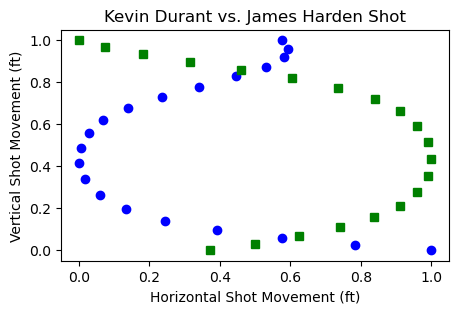

In [19]:
# Create a smaller figure
plt.figure(figsize=(5, 3))  # Adjust the values for width and height as needed

# Plotting the data with different colors
plt.plot(james_harden_x.tolist(), james_harden_y.tolist(), marker='o', linestyle='-', color='blue', label='Line 1')
plt.plot(kevin_durant_x.tolist(), kevin_durant_y.tolist(), marker='s', linestyle='--', color='green', label='Line 2')

# Adding labels and title
plt.xlabel('Horizontal Shot Movement (ft)')
plt.ylabel('Vertical Shot Movement (ft)')
plt.title('Kevin Durant vs. James Harden Shot')

Text(0.5, 1.0, 'Kevin Durant vs. James Harden Shot')

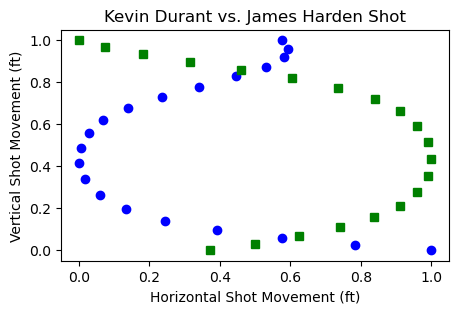

In [20]:
# Create a smaller figure
plt.figure(figsize=(5, 3))  # Adjust the values for width and height as needed

# Plotting the data with different colors
plt.plot(james_harden_x.tolist(), james_harden_y.tolist(), marker='o', linestyle='-', color='blue', label='Line 1')
plt.plot(kevin_durant_x.tolist(), kevin_durant_y.tolist(), marker='s', linestyle='--', color='green', label='Line 2')

# Adding labels and title
plt.xlabel('Horizontal Shot Movement (ft)')
plt.ylabel('Vertical Shot Movement (ft)')
plt.title('Kevin Durant vs. James Harden Shot')


Text(0.5, 1.0, 'Stephen Curry vs. Damian Lillard Shot')

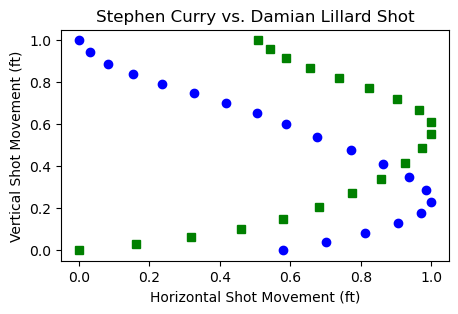

In [21]:
# Create a smaller figure
plt.figure(figsize=(5, 3))  # Adjust the values for width and height as needed

# Plotting the data with different colors
plt.plot(steph_curry_x.tolist(), steph_curry_y.tolist(), marker='o', linestyle='-', color='blue', label='Line 1')
plt.plot(dame_lilla_x.tolist(), dame_lilla_y.tolist(), marker='s', linestyle='--', color='green', label='Line 2')

# Adding labels and title
plt.xlabel('Horizontal Shot Movement (ft)')
plt.ylabel('Vertical Shot Movement (ft)')
plt.title('Stephen Curry vs. Damian Lillard Shot')


Text(0.5, 1.0, 'Stephen Curry vs. Damian Lillard Shot')

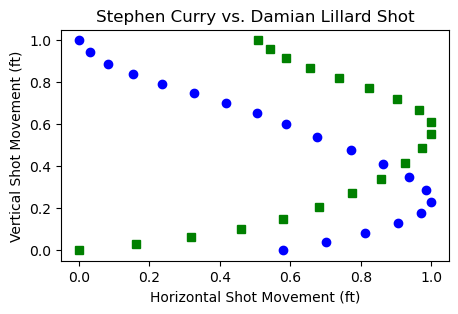

In [22]:
# Create a smaller figure
plt.figure(figsize=(5, 3))  # Adjust the values for width and height as needed

# Plotting the data with different colors
plt.plot(steph_curry_x.tolist(), steph_curry_y.tolist(), marker='o', linestyle='-', color='blue', label='Line 1')
plt.plot(dame_lilla_x.tolist(), dame_lilla_y.tolist(), marker='s', linestyle='--', color='green', label='Line 2')

# Adding labels and title
plt.xlabel('Horizontal Shot Movement (ft)')
plt.ylabel('Vertical Shot Movement (ft)')
plt.title('Stephen Curry vs. Damian Lillard Shot')

In [23]:
# scaled_path_detail_df = scaled_path_detail_df.drop(['pid'])

# # Combine 'fnm' and 'lnm' into a single column
scaled_path_detail_df['full_name'] = scaled_path_detail_df['fnm'] + ' ' + scaled_path_detail_df['lnm']

# # Drop the original 'fnm' and 'lnm' columns if they are no longer needed
scaled_path_detail_df = scaled_path_detail_df.drop(columns=['fnm', 'lnm'])

# Convert lists to strings
scaled_path_detail_df['cy_str'] = scaled_path_detail_df['cy'].apply(lambda x: ' '.join(map(str, x)))
scaled_path_detail_df['cz_str'] = scaled_path_detail_df['cz'].apply(lambda x: ' '.join(map(str, x)))

# Calculate mean values
scaled_path_detail_df['cy_mean'] = scaled_path_detail_df['cy'].apply(lambda x: np.mean(x))
scaled_path_detail_df['cz_mean'] = scaled_path_detail_df['cz'].apply(lambda x: np.mean(x))

# Drop the original list columns
scaled_path_detail_df = scaled_path_detail_df.drop(columns=['cy', 'cz'])
print(scaled_path_detail_df)

# Number of repetitions for each row (for example, 3 times)
# repetitions = 100

# Repeat each row
repeated_df = scaled_path_detail_df.loc[scaled_path_detail_df.index.repeat(1)].reset_index(drop=True)


# Drop the 'pid' column
repeated_x = repeated_df.drop(['pid'], axis=1)
repeated_y = repeated_df['full_name']

        pid       full_name  \
57   201142    Kevin Durant   
88   201935    James Harden   
91   201939   Stephen Curry   
125  202681    Kyrie Irving   
129  202691   Klay Thompson   
146  203081  Damian Lillard   

                                                cy_str  \
57   0.37126293167857605 0.49908378468476877 0.6244...   
88   1.0 0.7821143474158778 0.5759799883971807 0.39...   
91   0.5792421987984441 0.6999572187313892 0.811468...   
125  0.0 0.12720510086253506 0.24717305798693448 0....   
129  0.4431085471452963 0.5778465194186798 0.704139...   
146  0.0 0.16259314085555482 0.31915483138993533 0....   

                                                cz_str   cy_mean   cz_mean  
57   0.0 0.02929346614161299 0.06551088319437681 0....  0.649656  0.518902  
88   0.0 0.02468855193848185 0.05586326167596545 0....  0.337276  0.497958  
91   0.0 0.03852529245988601 0.08186024037014894 0....  0.577025  0.494186  
125  0.0 0.002943701931232723 0.012203635248590139 ...  0.665982  0

In [24]:
# Assuming repeated_df is your dataframe
# Features and target variable
X = repeated_df[['cy_str', 'cz_str', 'cy_mean', 'cz_mean']]
y = repeated_df['full_name']

print(len(X))
print(len(y))

# Drop rows with NaN values
X = X.dropna()
y = y[X.index]

# Splitting the dataset into develop data and final validation comparison
x_dev, x_val, y_dev, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Original Development Data Revenue Freq:")
print(y_dev.value_counts(), "\n")

# Apply SMOTE to only the numeric features
numeric_features = ['cy_mean', 'cz_mean']
string_features = ['cy_str', 'cz_str']

# Extract numeric features
x_dev_numeric = x_dev[numeric_features]

# Apply SMOTE
ros = SMOTE(random_state=42)
x_dev_numeric_os, y_dev_os = ros.fit_resample(x_dev_numeric, y_dev)
print("Oversampled Development Data Revenue Freq:")
print(y_dev_os.value_counts(), "\n")

# To combine the oversampled numeric features with original string features
# First, find the number of new samples created by SMOTE
num_new_samples = len(x_dev_numeric_os) - len(x_dev_numeric)

# Extract the original string features
x_dev_string = x_dev[string_features]

# Randomly select original string features to match the number of new samples
new_string_samples = x_dev_string.sample(num_new_samples, replace=True, random_state=42)

# Concatenate original and new string features
x_dev_string_os = pd.concat([x_dev_string, new_string_samples], ignore_index=True)

# Combine oversampled numeric features with string features
x_dev_os = pd.concat([pd.DataFrame(x_dev_numeric_os, columns=numeric_features), x_dev_string_os], axis=1)

# Drop any remaining NaN values
x_dev_os = x_dev_os.dropna()
y_dev_os = y_dev_os[x_dev_os.index]

# Splitting the oversampled dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_dev_os, y_dev_os, test_size=0.2, random_state=42)

print("Training Data Shape:", x_train.shape)
print("Testing Data Shape:", x_test.shape)
print("Training Labels Shape:", y_train.shape)
print("Testing Labels Shape:", y_test.shape)


6
6
Original Development Data Revenue Freq:
full_name
Damian Lillard    1
Stephen Curry     1
Klay Thompson     1
Kyrie Irving      1
Name: count, dtype: int64 

Oversampled Development Data Revenue Freq:
full_name
Damian Lillard    1
Stephen Curry     1
Klay Thompson     1
Kyrie Irving      1
Name: count, dtype: int64 

Training Data Shape: (3, 4)
Testing Data Shape: (1, 4)
Training Labels Shape: (3,)
Testing Labels Shape: (1,)


In [25]:
x_train.head()

,cy_mean,cz_mean,cy_str,cz_str
3,0.665982,0.400252,0.0 0.12720510086253506 0.24717305798693448 0....,0.0 0.002943701931232723 0.012203635248590139 ...
0,0.672549,0.497212,0.0 0.16259314085555482 0.31915483138993533 0....,0.0 0.02853379024629532 0.0626913932302895 0.1...
2,0.652512,0.485290,0.4431085471452963 0.5778465194186798 0.704139...,0.0 0.01806584613150708 0.04322015855033012 0....


In [26]:

# print(x_train[1]['cy_str'])
# print(x_train[:1]['cy_str'])
print(x_train.iloc[0]['cy_str'])
print(x_train.iloc[0]['cz_str'])


0.0 0.12720510086253506 0.24717305798693448 0.35230312670304753 0.44897034061292795 0.5584025649630573 0.6724335047489763 0.7819178401432758 0.877710251318544 0.950665418447371 0.9916442708038827 0.9999999999999999 0.9837591439819883 0.9478909611760448 0.8973647100083659 0.8371496489051481 0.7722150362925878 0.7065934411653325 0.6284218991920966 0.5378183515686928
0.0 0.002943701931232723 0.012203635248590139 0.030123093830629277 0.05815041357238293 0.09476525423757054 0.1386033555275914 0.18833587133087548 0.24263395553585154 0.3001687620309489 0.3596185893835363 0.42603768781669527 0.5019164936378525 0.5833328903099199 0.6663647612958071 0.7470899900584248 0.8215864600606831 0.8862791629405687 0.9448851131818107 1.0


In [27]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer

# Define custom transformers
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

# Combine the transformers using FeatureUnion
features = FeatureUnion([
    ('cy_str', make_pipeline(TextSelector(key='cy_str'), CountVectorizer())),
    ('cz_str', make_pipeline(TextSelector(key='cz_str'), CountVectorizer())),
    ('cy_mean', NumberSelector(key='cy_mean')),
    ('cz_mean', NumberSelector(key='cz_mean'))
])
# Create the final pipeline
pipeline = Pipeline([
    ('features', features),
    ('classifier', GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42))
])

# Train the model
pipeline.fit(x_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.00
Classification Report:
                precision    recall  f1-score   support

Damian Lillard       0.00      0.00      0.00       0.0
 Stephen Curry       0.00      0.00      0.00       1.0

      accuracy                           0.00       1.0
     macro avg       0.00      0.00      0.00       1.0
  weighted avg       0.00      0.00      0.00       1.0



/Users/ksuvarna47/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ksuvarna47/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ksuvarna47/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ksuvarna47/ana

In [28]:
# Assuming you have a trained model named `pipeline`
# and a new data point with generated random data
random_data = {
    'cy_mean': [0.6],
    'cz_mean': [0.4852],
    'cy_str': ["0.4431085471452963 0.5778465194186798 0.7041391752401353 0.8100715792290154 0.8844973281816337 0.9374203447455969 0.9750166754946296 0.9962290005417563 0.9999999999999999 0.9852723539823839 0.9509887426019317 0.89492077041692 0.8024719550162913 0.6797011930881728 0.5396875450186615 0.39551007119385606 0.2602478319998524 0.14697988782274996 0.06612596857596019 0.0"],
    'cz_str': ["0.0 0.01806584613150708 0.04322015855033012 0.07672393739303007 0.11997828520503473 0.17638519703765565 0.24390418043222895 0.3184593961642378 0.3959750050091645 0.4723751677424922 0.5435840451397046 0.6059288174723315 0.6627207363353741 0.7162336440437781 0.7670877674625333 0.8159033334566296 0.8633005688910561 0.9098997006308028 0.9560624167924975 1.0"]
}

# Create a DataFrame with the generated random data
new_data_df = pd.DataFrame(random_data)

# Predict the label for the new data point
predicted_label = pipeline.predict(new_data_df)

# Print the predicted label
print("Predicted Label:", predicted_label)


Predicted Label: ['Klay Thompson']


In [30]:
# Save the model
dump(pipeline, 'predictorModel.joblib')

['predictorModel.joblib']